# Stratify

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Static data
counties, counties_date = load_counties()

In [3]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, ma_width=7, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

In [4]:
deaths_df.columns

Index(['FIPS', 'day_01', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06',
       'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'onset', 'Beds', 'HospCt', 'OD_baseline', 'OD_at_onset',
       'OD_2wk_before_onset', 'OD_2wk_after_onset',
       'Rural-urban_Continuum Code_2013',
       'Density per square mile of land area - Population',
       'Percent of adults with less than a high school diploma 2014-18',
       'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus',
       'POP_ESTIMATE_2018', 'onset_relative'],
      dtype='object')

In [5]:
ddf = deaths_df.copy()
ddf[days] = ddf[days].divide(ddf['POP_ESTIMATE_2018'], axis=0)
print(ddf.shape)

(600, 44)


## Stratify first

In [6]:
ddf['OD_at_onset_normalized'] = ddf['OD_at_onset'] / ddf['OD_baseline']
ddf['OD_2wk_before_onset_normalized'] = ddf['OD_2wk_before_onset'] / ddf['OD_baseline']
ddf['OD_2wk_after_onset_normalized'] = ddf['OD_2wk_after_onset'] / ddf['OD_baseline']

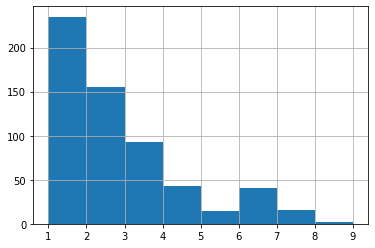

In [7]:
ddf['Rural-urban_Continuum Code_2013'].hist(bins=np.arange(1,10))

### Specific RUCC

In [8]:
RUCC = 3
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

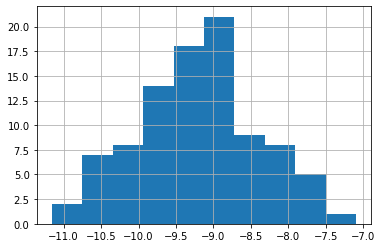

In [9]:
strat_df['day_25'].transform('log').hist()

In [87]:
## Bins
N_BINS = 4
var = 'POP_ESTIMATE_2018'
_, bins = np.histogram(strat_df[var], bins=N_BINS)
strat_df['binned_pop'] = pd.cut(
    strat_df[var],
    bins=bins,
    labels=np.arange(1,len(bins)),
    include_lowest=True
)

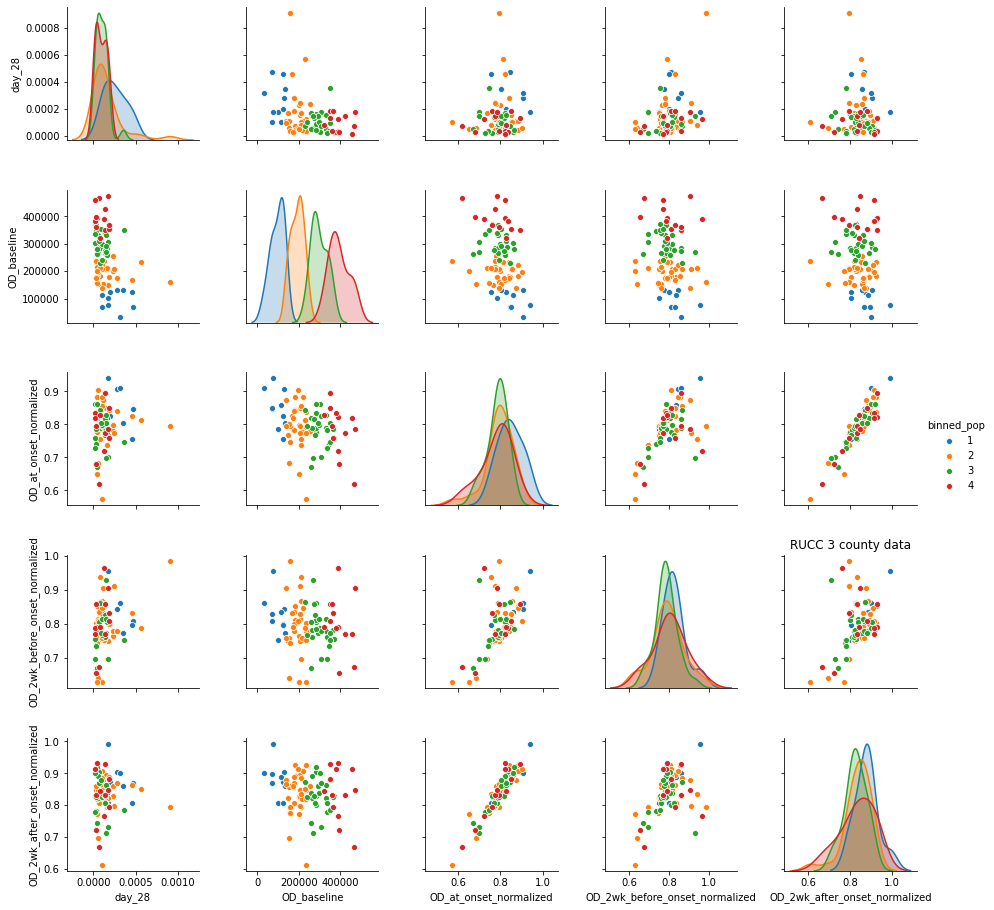

In [50]:
vars = [
    'day_28',
    'OD_baseline',
    'OD_at_onset_normalized',
    'OD_2wk_before_onset_normalized',
    'OD_2wk_after_onset_normalized',
]
hue = 'binned_pop'
sns.pairplot(strat_df, vars=vars, hue=hue)
plt.title(f'RUCC {3} county data')
plt.show()

### Regress out confounder effects

In [109]:
from sklearn.linear_model import LinearRegression, GammaRegressor, PoissonRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [195]:
strat_df['POP_ESTIMATE_2018 (log)'] = strat_df['POP_ESTIMATE_2018'].transform('log')

In [196]:
X = strat_df[[
    'OD_baseline',
    'OD_at_onset_normalized',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
]]
y = strat_df['day_25'].values

(array([39., 29.,  4.,  5.,  1.,  2.,  1.,  0.,  0.,  1.]),
 array([1.30309572e-05, 9.45522191e-05, 1.76073481e-04, 2.57594743e-04,
        3.39116005e-04, 4.20637266e-04, 5.02158528e-04, 5.83679790e-04,
        6.65201052e-04, 7.46722314e-04, 8.28243576e-04]),
 <a list of 10 Patch objects>)

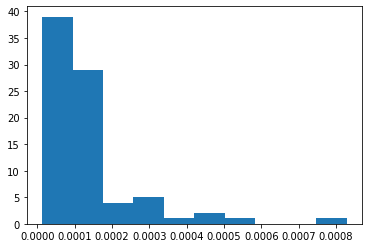

In [197]:
plt.hist(y)

In [200]:
scaler = StandardScaler()
lr = GammaRegressor(alpha=0.5, max_iter=300)#()

X = scaler.fit_transform(X)
lr = lr.fit(X,y)
print(lr.coef_)
print(lr.score(X,y))

[-0.11528191 -0.04457023  0.16906331 -0.14330378]
0.23601617005969044


(array([1., 0., 1., 3., 2., 7., 8., 4., 5., 2.]),
 array([-14.40768038, -13.7100048 , -13.01232922, -12.31465364,
        -11.61697806, -10.91930248, -10.2216269 ,  -9.52395132,
         -8.82627574,  -8.12860016,  -7.43092458]),
 <a list of 10 Patch objects>)

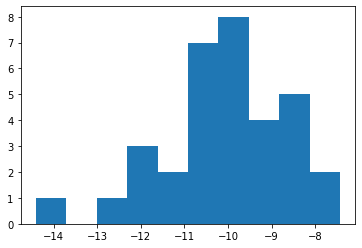

In [201]:
plt.hist(np.log(y - lr.predict(X)))

### Account for regression

In [202]:
dtw_df = strat_df.copy()

In [203]:
dtw_df[days] = dtw_df[days].divide(lr.predict(X), axis=0)

## DTW on residuals

In [170]:
def DTWDistance(s1, s2,w=3):
    s1 = s1[s1 >= 0]
    s2 = s2[s2 >= 0]
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
		
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [169]:
X = dtw_df[days].values

In [171]:
X_dists = pairwise_distances(X, metric=DTWDistance)

In [185]:
linkage = 'average'
n_clusters = np.arange(2,10,1)
for n_clusters in n_clusters:
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage=linkage,
        affinity='precomputed'
    ).fit(X_dists)
    score = silhouette_score(X_dists, clustering.labels_, metric='precomputed')
    print(f'{n_clusters}: {score}')

2: 0.7090364729391548
3: 0.6004509471889392
4: 0.6080558912842289
5: 0.5990923952894939
6: 0.5912736089327344
7: 0.5255207435273618
8: 0.49071171136230274
9: 0.4709798714103629


In [186]:
def plot(labels, label, n = 5, show=True):
    idxs = np.where(labels == label)[0][:n]
    n = min(len(idxs), n)
    fig,axes = plt.subplots(n,1,figsize=(1.5*5,1.5*n), sharex=True)
    if n == 1:
        axes = [axes]
    for i,idx in enumerate(idxs):
        y = X[idx]
        FIPS = ddf.iloc[idx]['FIPS']
        l = ', '.join(counties[counties['FIPS'] == FIPS][['Area_Name', 'State']].values[0])
        axes[i].plot(np.arange(len(y)), y, label=l)
        axes[i].legend(loc='upper left')
    axes[0].set_title(f'Cluster {label+1}, Size={len(np.where(labels == label)[0])}')
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(f'../figures/dtw_cluster-{label+1}.pdf')
    plt.close()

In [187]:
clustering = AgglomerativeClustering(n_clusters=6, linkage=linkage, affinity='precomputed').fit(X_dists)

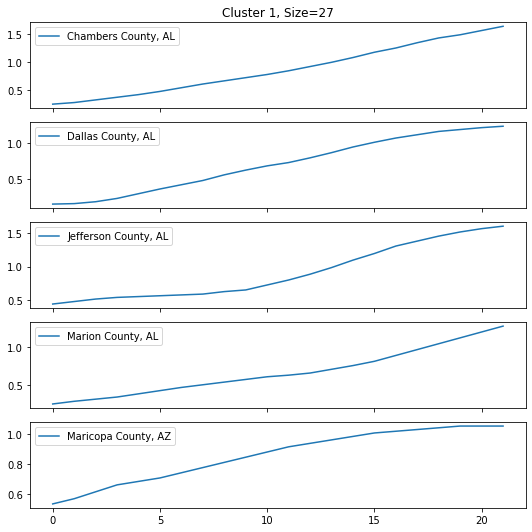

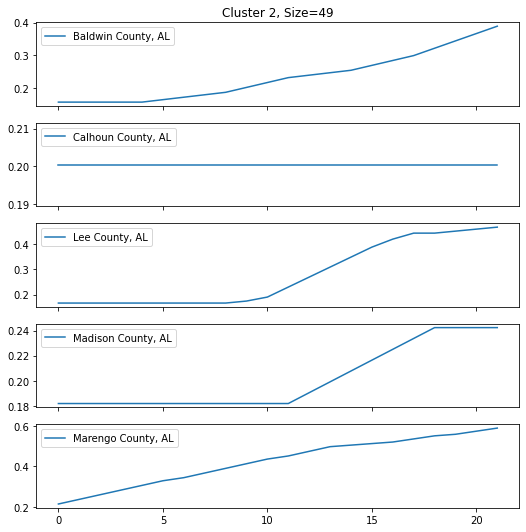

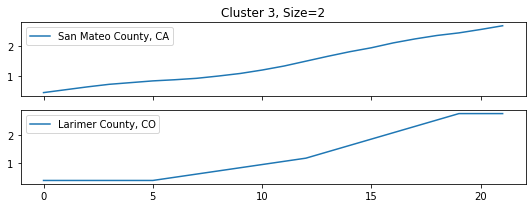

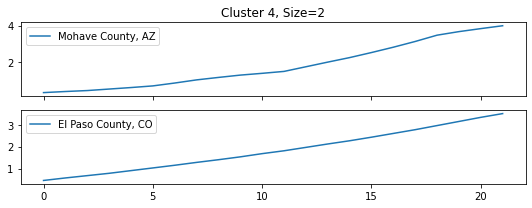

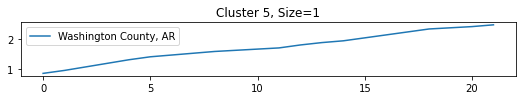

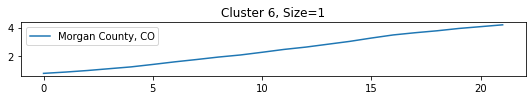

In [188]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5, show=True)